In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
# load all dfs
enrichr_df = pd.read_csv("enr_data/Enrichr_df.csv", index_col=0) # sorted by Term alphabetically
offline_df = pd.read_csv("enr_data/offline_df.csv", index_col=0) # sorted by Term alphabetically
string_df = pd.read_csv("enr_data/string_df.csv", index_col=0) # already sorted by fdr & by raw p-value
gsea_df = pd.read_csv("enr_data/gsea_df.csv", index_col=0) # sorted by absoulte NES
preranked_df = pd.read_csv("enr_data/preranked_df.csv", index_col=0) # sorted by absoulte NES

In [3]:
# sorting
enrichr_df.sort_values(by=['Adjusted P-value'], inplace=True, ascending=True)
offline_df.sort_values(by=['Adjusted P-value'], inplace=True, ascending=True)
enrichr_df.reset_index(drop=True, inplace=True)
offline_df.reset_index(drop=True, inplace=True)

In [4]:
# make index ranks
enrichr_df.index = enrichr_df.index + 1
offline_df.index = offline_df.index + 1
string_df.index = string_df.index + 1
gsea_df.index = gsea_df.index + 1
preranked_df.index = preranked_df.index + 1

In [5]:
print(enrichr_df.iloc[:10, 1:5].drop(columns=["Overlap", "P-value", "Adjusted P-value"]))
# a lot of duplicate values
# print(string_df["description"])

                                                 Term
1        Response to elevated platelet cytosolic Ca2+
2                              Platelet degranulation
3      Platelet activation, signaling and aggregation
4          Intrinsic Pathway of Fibrin Clot Formation
5          Post-translational protein phosphorylation
6   Regulation of Insulin-like Growth Factor (IGF)...
7         Formation of Fibrin Clot (Clotting Cascade)
8                       Retinoid cycle disease events
9                                  Alanine metabolism
10                    Diseases of the neuronal system


In [6]:
# functions
def jaccard_similarity(A, B):
    nominator = A.intersection(B)
    denominator = A.union(B)
    similarity = len(nominator)/len(denominator)
    return similarity

def mean_rank_difference(rank_dict_a, rank_dict_b):
    total_diff = 0

    for element, rank_b in rank_dict_b.items():
        if element in rank_dict_a:
            rank_a = rank_dict_a[element]
            rank_diff = abs(rank_a - rank_b)
            total_diff += rank_diff

    mean_rank_diff = total_diff / len(rank_dict_b)
    return mean_rank_diff

## check if enrichr and offline are the same

In [7]:
enrichr_df.compare(offline_df, align_axis=1, keep_shape=True)
all(enrichr_df == offline_df)

True

compare GO enrichment methods

In [8]:
print("number of")
print("enriched terms GSEApy", enrichr_df.shape[0], "enriched terms STRING", string_df.shape[0])

number of
enriched terms GSEApy 224 enriched terms STRING 5


In [9]:
# Can all of the string enriched terms be found in GSEApy results?
for term in string_df["description"].tolist():
    if term not in enrichr_df["Term"].tolist():
        print(term)
    else:
        print("found")

found
found
found
found
found


In [10]:
for col in enrichr_df.columns: # on column to find out if already sorted
    print(col, enrichr_df[col].is_monotonic_increasing)

Gene_set True
Term False
Overlap False
P-value False
Adjusted P-value True
Odds Ratio False
Combined Score False
Genes False
Proteins False


In [11]:
overlap_df = enrichr_df.loc[enrichr_df["Term"].isin(string_df["description"].tolist())]
print(overlap_df)

                Gene_set                                               Term  \
2   ReactomePathways.gmt                             Platelet degranulation   
4   ReactomePathways.gmt         Intrinsic Pathway of Fibrin Clot Formation   
5   ReactomePathways.gmt         Post-translational protein phosphorylation   
6   ReactomePathways.gmt  Regulation of Insulin-like Growth Factor (IGF)...   
13  ReactomePathways.gmt                                         Hemostasis   

   Overlap       P-value  Adjusted P-value  Odds Ratio  Combined Score  \
2     9/82  2.466298e-07          0.000034   11.758513      178.910215   
4     4/15  1.838297e-05          0.000877   27.238770      297.013883   
5     6/51  1.958012e-05          0.000877   12.213309      132.404435   
6     6/56  3.379333e-05          0.001262   11.121316      114.496698   
13  11/288  3.079131e-04          0.005306    4.068858       32.899538   

                                                Genes  \
2   APOA1;AHSG;KNG1;ITI

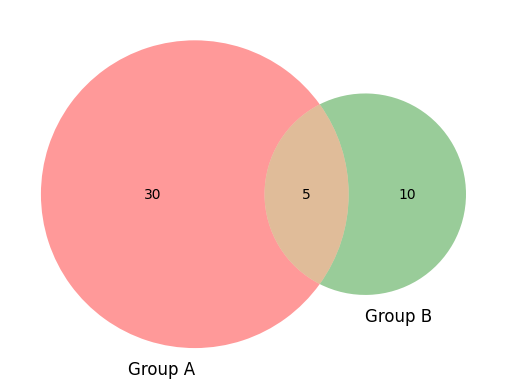

In [17]:
# venn diagram
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
venn2(subsets = (30, 10, 5), set_labels = ('Group A', 'Group B'))

In [12]:
# jaccard index
enrichr_terms = enrichr_df["Term"]
string_terms = string_df["description"]

enrichr_terms_s = set(enrichr_df["Term"])
string_terms_s = set(string_df["description"])
print("jaccard index", jaccard_similarity(enrichr_terms_s, string_terms_s))

enrichr_top_ten = set(enrichr_df.loc[:10, "Term"])
print("jaccard top ten", jaccard_similarity(enrichr_top_ten, string_terms))

enrichr_top_ten = set(enrichr_df.loc[:5, "Term"])
print("jaccard top five", jaccard_similarity(enrichr_top_ten, string_terms))

jaccard index 0.022321428571428572
jaccard top ten 0.36363636363636365
jaccard top five 0.42857142857142855


In [13]:
string_dict = dict(zip(string_df["description"], string_df.index))
overlap_dict = dict(zip(overlap_df["Term"], overlap_df.index))
# print(string_dict)
# print(overlap_dict)
print("mean rank difference", mean_rank_difference(string_dict, overlap_dict))

mean rank difference 3.4


In [14]:
# pearson correlation of ranks
print(x := np.array(list(string_dict.values())))
print(y := overlap_df.index.tolist())
print("numpy", np.corrcoef(x,y))
print("scipy", scipy.stats.pearsonr(x, y))

# print("spearman", pd.Series(overlap_df.index).corr(pd.Series(string_df.index), method="spearman"))
# xy = np.array([np.array(list(string_dict.values())),np.array(overlap_df.index)], dtype=object)
# print(np.array(list(string_dict.values())))
# print(np.array(overlap_df.index))
# print(scipy.stats.spearmanr(xy, axis=1))

[1 2 3 4 5]
[2, 4, 5, 6, 13]
numpy [[1.         0.90711474]
 [0.90711474 1.        ]]
scipy PearsonRResult(statistic=0.9071147352221454, pvalue=0.03350493454730273)


Regression line: y=-1.20+2.40x, r=0.91


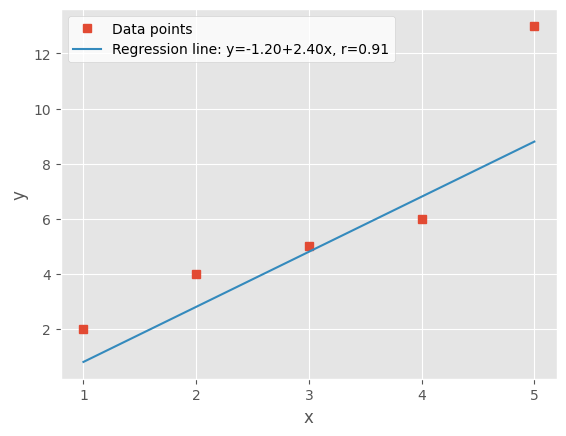

In [15]:
# plot
plt.style.use('ggplot')
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + int(slope) * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
ax.set_xticks(range(int(min(x)), int(max(x)) + 1))
plt.savefig("pearson_GO.pdf", dpi=300)
plt.show()

## GSEA Methods

In [16]:
# sorted by absolute NES value
copied_df = gsea_df.copy(deep=True)
gsea_df["abs_NES"]=gsea_df["NES"].abs()
print(gsea_df["abs_NES"].is_monotonic_decreasing)
gsea_df.drop(columns="abs_NES")
print((copied_df == gsea_df).all())
#---
copied_df = preranked_df.copy(deep=True)
preranked_df["abs_NES"]=preranked_df["NES"].abs()
print(preranked_df["abs_NES"].is_monotonic_decreasing)
preranked_df.drop(columns="abs_NES")
print((copied_df == preranked_df).all())

True


ValueError: Can only compare identically-labeled DataFrame objects

In [ ]:
print(gsea_df.iloc[:10,1:2])
# print(preranked_df.iloc[:10,1:2])